# **IBL - Processed Widefield Imaging Data**

This tutorial shows how to access data from <[DANDI:00XXXX](https://dandiarchive.org/dandiset/00XXXX/draft)> for the IBL widefield dataset.

## Study Overview

[TODO add description]

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Processed Imaging Data and Metadata](#processed)
4. [Landmarks](#landmarks)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [2]:
# Core data manipulation and analysis
# Visualization
import matplotlib.pyplot as plt

# NWB access
from pynwb import read_nwb

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Read NWB file from local path

You can read the NWB file from a local path using `pynwb.read_nwb()`.

In [3]:
subject_id = "CSK-im-011"  # Example subject
session_id = "84565bbe-fd4c-4bdb-af55-968d46a4c424"  # EID for the session

# Read NWB file from local path
nwbfile_path = f"/Volumes/T9/data/IBL/nwbfiles/processed/sub-CSK-im-011_ses-84565bbe-fd4c-4bdb-af55-968d46a4c424.nwb"
nwbfile = read_nwb(nwbfile_path)

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [4]:
print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

print("\n=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.species}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SESSION INFORMATION ===
Experiment description:
 None
Session description:
 A rich text description of the experiment. Can also just be the abstract of the publication.
Session start time:
 2020-01-01 00:00:00-05:00

=== SUBJECT INFORMATION ===
ID: a_subject_id
Age: TBD
Strain: Mus musculus
Genotype: None
Sex: U


---

# 3. Processed Imaging Data and Metadata <a id="processed"></a>

## Temporal components


The SVD temporal components are stored in the `ophys` processing module within the "SVDTemporalComponents" container.

Data shape
- Arrays are shaped `(time, num_components)` — the first dimension is time (frame), the second is the number of components.


Denoised/decomposed series names:
- Calcium (470 nm): `DenoisedSVDTemporalComponentsCalcium`
- Isosbestic (405 nm): `DenoisedSVDTemporalComponentsIsosbestic`
Haemodynamically corrected series name:
- Calcium (470 nm): `HaemoCorrectedSVDTemporalComponentsCalcium`

Access example
```python
SVD_temporal_components = nwbfile.processing["ophys"]["SVDTemporalComponents"]["DenoisedSVDTemporalComponentsCalcium"]
```

In [5]:
print(f"=== SVD Temporal components: ===")
print("-" * 100)
svd_module = nwbfile.processing["ophys"]["SVDTemporalComponents"]
for _, temporal_components in svd_module.roi_response_series.items():
    print(f"Trace: {temporal_components.name}")
    print("-" * 100)
    print(f"   Description: {temporal_components.description}")
    print(f"   Number of ROIs: {temporal_components.data.shape[1]}")
    print(f"   Duration: {temporal_components.timestamps[-1] - temporal_components.timestamps[0]:.2f} seconds")
    print("-" * 100)

=== SVD Temporal components: ===
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Blue light (470 nm) excitation.
   Number of ROIs: 200
   Duration: 4989.12 seconds
----------------------------------------------------------------------------------------------------
Trace: DenoisedSVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: SVD temporal components (denoised/decomposed) of widefield calcium imaging from Violet light (405 nm) excitation.
   Number of ROIs: 200
   Duration: 4989.12 seconds
----------------------------------------------------------------------------------------------------
Trace: Ha

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), dpi=200, sharex=True, sharey=True)

num_rois = 5
roi_response = svd_module.roi_response_series["DenoisedSVDTemporalComponentsCalcium"]
time = roi_response.timestamps[:1000]  # First 1000 time points
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[0].plot(time, roi_response.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[0].set_title('Uncorrected Temporal Components (Calcium)')
ax[0].set_ylabel('a.u.')
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[0].set_frame_on(False)

roi_response_iso = svd_module.roi_response_series["DenoisedSVDTemporalComponentsIsosbestic"]
for roi_idx in range(num_rois):  # Plot first 5 ROIs
    ax[1].plot(time, roi_response_iso.data[:1000, roi_idx], label=f'Component {roi_idx+1}')
ax[1].set_title('Uncorrected Temporal Components (Isosbestic)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('a.u.')
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax[1].set_frame_on(False)
plt.tight_layout()

In [7]:
fig, ax = plt.subplots(dpi=200)

roi_response_dff = svd_module["HaemoCorrectedSVDTemporalComponentsCalcium"]
roi_response_raw = svd_module["DenoisedSVDTemporalComponentsCalcium"]

time = roi_response_raw.timestamps[:1000]  # First 1000 time points
ax.plot(time, roi_response_raw.data[:1000, 0], label="uncorrected", color="grey", alpha=0.2)
ax.plot(time, roi_response_dff.data[:1000, 0], label="haemocorrected", color="green", alpha=0.8)
ax.set_title('Haemocorrected Temporal Component (Calcium)')
ax.set_ylabel('a.u.')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_frame_on(False)

The image masks for each field are stored in `PlaneSegmentation` objects in an `ImageSegmentation` container within the "ophys" processing module.

In [8]:
print(f"=== Spatial Components: ===")
print("-" * 100)
spatial_components_module = nwbfile.processing["ophys"]["SVDSpatialComponents"]
for _, plane_segmentation in spatial_components_module.plane_segmentations.items():
    print(f"Plane Segmentation: {plane_segmentation.name}")
    print("-" * 100)
    print(f"   Description: {plane_segmentation.description}")
    print(f"   Linked Imaging Plane: {plane_segmentation.imaging_plane.name}")
    print(f"   ROIs properties: {plane_segmentation.colnames}")
    print("-" * 100)

=== Spatial Components: ===
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsCalcium
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneCalcium
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------
Plane Segmentation: SVDTemporalComponentsIsosbestic
----------------------------------------------------------------------------------------------------
   Description: Spatial components for widefield calcium imaging.
   Linked Imaging Plane: ImagingPlaneIsosbestic
   ROIs properties: ('roi_name', 'image_mask')
----------------------------------------------------------------------------------------------------


In [9]:
plane_segmentation = spatial_components_module["SVDTemporalComponentsCalcium"]
# view plane segmentation table
plane_segmentation.to_dataframe()

,roi_name,image_mask
id,,
0,0,"[[0.049625162, 0.04772705, 0.04183665, 0.04222..."
1,1,"[[0.06113025, 0.059140597, 0.052058227, 0.0520..."
2,2,"[[-0.0446905, -0.04079102, -0.036529366, -0.04..."
3,3,"[[0.009191629, 0.007498737, 0.007333804, 0.007..."
4,4,"[[-0.010197174, -0.009974919, -0.0036508574, -..."
...,...,...
195,195,"[[0.030825567, -0.00015199045, -0.011743266, 0..."
196,196,"[[-0.007716487, 0.0056951162, -0.048174288, 0...."
197,197,"[[0.011774059, -0.031466763, -0.086726286, -0...."


In [10]:
plane_segmentation["image_mask"].shape

(200, 540, 640)

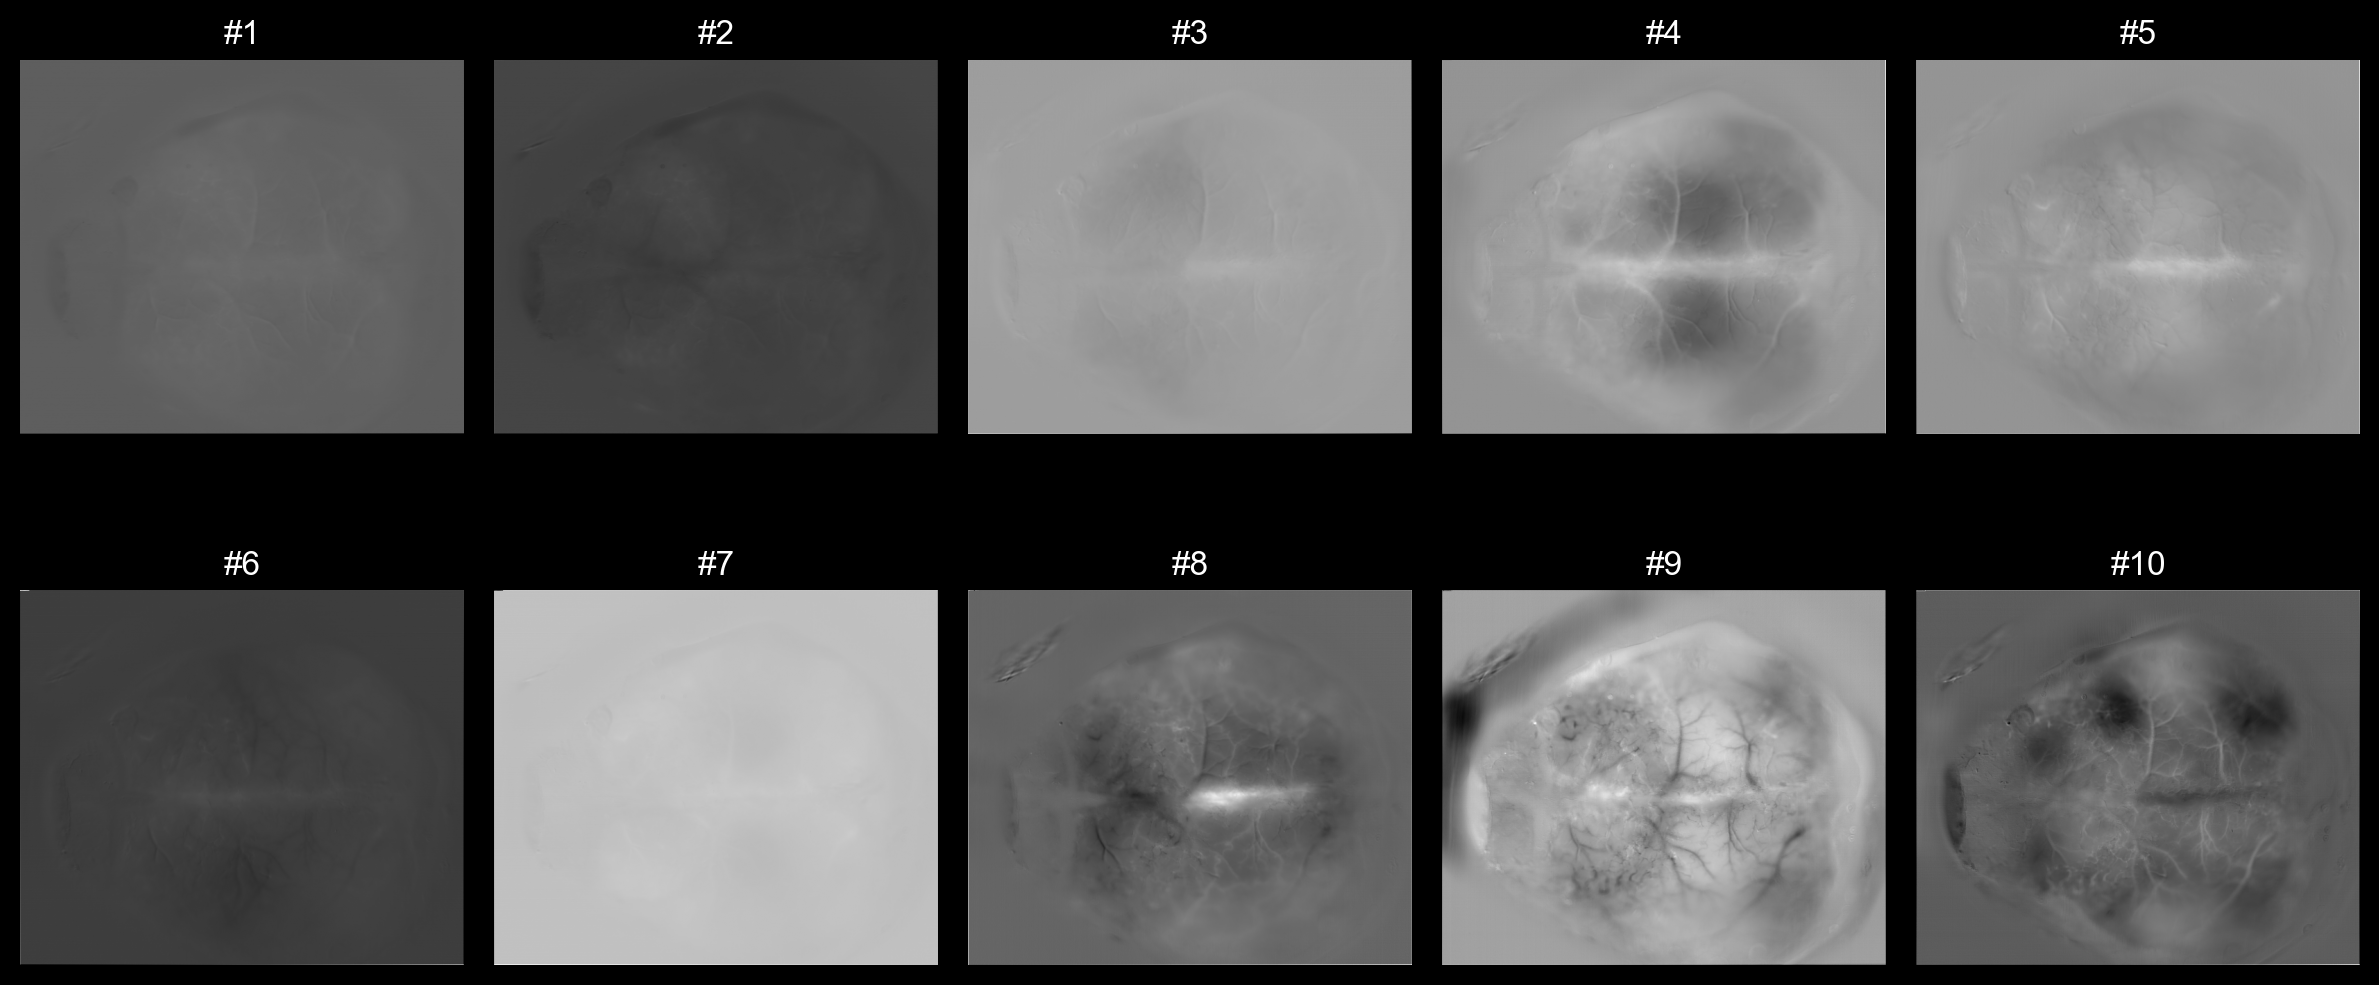

In [20]:
# view example spatial components
roi_ids = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)
for ax, roi_id in zip(axes.flatten(), roi_ids):
    ax.imshow(plane_segmentation["image_mask"][roi_id], cmap="gray")
    ax.set_title(f'#{roi_id + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The summary images are stored in GrayscaleImage objects in an Images container within the "ophys" processing module.


In [12]:
print(f"=== SUMMARY IMAGES: ===")
print("-" * 100)
summary_images = nwbfile.processing["ophys"]["SummaryImages"]
for _, summary_image in summary_images.images.items():
    print(f"Image: {summary_image.name}")
    print("-" * 100)
    print(f"   Description: {summary_image.description}")
    print(f"   Dimensions: {summary_image.data.shape}")
    print("-" * 100)

=== SUMMARY IMAGES: ===
----------------------------------------------------------------------------------------------------
Image: MeanImage
----------------------------------------------------------------------------------------------------
   Description: The mean image under Blue (470 nm) excitation across the imaging session.
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------
Image: MeanImageIsosbestic
----------------------------------------------------------------------------------------------------
   Description: The mean image under Violet (405 nm) excitation across the imaging session.
   Dimensions: (540, 640)
----------------------------------------------------------------------------------------------------


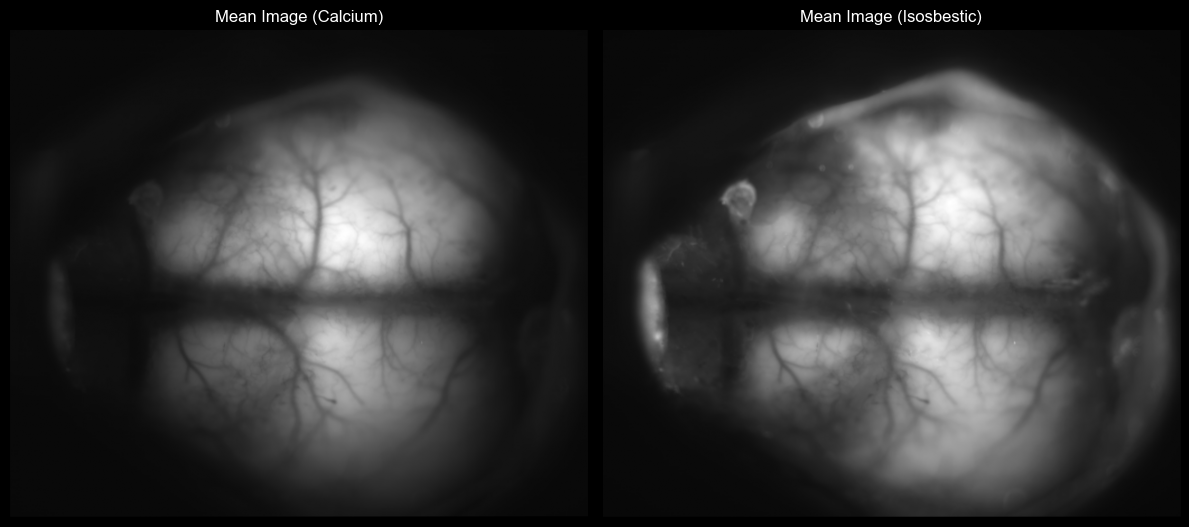

In [13]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

mean_image = summary_images.images["MeanImage"]
axes[0].imshow(mean_image, cmap="gray")
axes[0].set_title('Mean Image (Calcium)')
axes[0].axis('off')

mean_image_isosbestic = summary_images.images["MeanImageIsosbestic"]
axes[1].imshow(mean_image_isosbestic, cmap="gray")
axes[1].set_title('Mean Image (Isosbestic)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Aligning data to the Allen reference atlas using Landmarks <a id="landmarks"></a>

The imaging stack can be reconstructed from the decomposed spatial and temporal components of the SVD. The imaging stack contains the imaging data for each frame in the session and has dimensions (time, height, width).

In [21]:
spatial_transformation_metadata = nwbfile.lab_meta_data["SpatialTransformationMetadata"]
spatial_transformation_metadata

KeyError: 'SpatialTransformationMetadata'

In [ ]:
similarity_transformation = spatial_transformation_metadata.spatial_transformations["SimilarityTransformation"]

print("=== Transform ===")
print("-" * 100)
print(f"Source Image: {summary_images.images["MeanImage"].name}")
print("-" * 100)
print(f"   rotation matrix: {similarity_transformation.rotation_matrix[:]}")
print(f"   scale: {similarity_transformation.scale}")
print(f"   translation: {similarity_transformation.translation_vector[:]}")

In [ ]:
import numpy as np
from skimage.transform import SimilarityTransform

rotation_matrix = similarity_transformation.rotation_matrix[:]
translation = similarity_transformation.translation_vector[:]
M = np.array([
    [rotation_matrix[0, 0], rotation_matrix[0, 1], translation[0]],
    [rotation_matrix[1, 0], rotation_matrix[1, 1], translation[1]],
    [0.0, 0.0, 1.0],
])

np.rad2deg(SimilarityTransform(M).rotation)

In [ ]:
from skimage.transform import SimilarityTransform

transform = similarity_transformation.rotation_matrix[:].tolist()
transform.extend(similarity_transformation.translation_vector[:].tolist())

transform


In [ ]:
similarity_transformation.translation_vector[:].tolist()

In [ ]:
transformed_images = nwbfile.processing["ophys"]["TransformedImages"]
mean_image_transformed = transformed_images["MeanImageTransformed"]


fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

mean_image = summary_images.images["MeanImage"]
axes[0].imshow(mean_image.data[:], cmap="gray")
axes[0].set_title('Source Image (height x width)')
axes[0].axis('off')
axes[1].imshow(mean_image_transformed, cmap="gray")
axes[1].set_title('Target Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
landmarks = spatial_transformation_metadata.landmarks["Landmarks"]
landmarks[:]

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)


landmarks_df = landmarks[:]

mean_image = summary_images.images["MeanImage"]
axes[0].imshow(mean_image.data[:], cmap="gray")
axes[0].set_title('Source Image')
axes[0].axis('off')
axes[1].imshow(mean_image_transformed, cmap="gray")
axes[1].set_title('Target Image')
axes[1].axis('off')

for i, row in landmarks_df.iterrows():
    axes[0].plot(row["source_coordinates"][0], row["source_coordinates"][1],'g+',ms=18) # the matched coordinates in the original image space
    axes[1].plot(row["target_coordinates"][0], row["target_coordinates"][1],'rx',ms=18) # the coordinates registered to the atlas
    axes[1].text(row["target_coordinates"][0], row["target_coordinates"][1], row['landmark_labels'],color='w',fontsize=12,va='bottom',ha='center')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
import wfield

# Load the spatial components
U = plane_segmentation["image_mask"].data[:]
print(f"Spatial components shape: {U.shape}")
# Load the haemocorrected temporal components
SVT = roi_response_dff.data[:]
print(f"Temporal components shape: {SVT.shape}")
# Use wfield package to build imaging stack
stack = wfield.SVDStack(U, SVT.T) # this then needs to be added to the NWB file
print(f"Reconstructed stack shape: {stack.shape}")

In [ ]:
# Warp and register the image stack to the Allen dorsal cortex
stack.set_warped(True, M=similarity_transformation.get_transform_matrix())

In [ ]:
# first 10 frames
frames = range(10)

fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, dpi=200)
for ax, frame_ind in zip(axes.flatten(), frames):
    ax.imshow(stack[frame_ind], cmap="gray")
    ax.set_title(f'ImageStack#{frame_ind}')
    ax.axis('off')
plt.tight_layout()
plt.show()
